In [1]:
import pandas as pd
import re
import struct
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

from scipy.signal import find_peaks
import matplotlib.colors as mcolors

current_dir = '/home/marian/CIGAR_ANALYSIS/CIGAR/notebooks'

# Build the absolute path to ../functions
functions_path = os.path.abspath(os.path.join(current_dir, '../functions'))

# Add it to sys.path
sys.path.append(functions_path)

import parse_data 
import cigar as cig

from tqdm import tqdm


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
colors = ['royalblue', 'crimson', 'black', 'green', 'darkorange', 'brown', 'coral', 'indigo', 'magenta']


##  Data reading

In [3]:

run_noKr         = 'Run11'
run_noKr_dir     = f"/home/marian/CIGAR_ANALYSIS/CIGAR/data/{run_noKr}"

run_Kr         = 'Run12'
run_Kr_dir     = f"/home/marian/CIGAR_ANALYSIS/CIGAR/data/{run_Kr}"

nchannels       = 9
nevents_per_wvf = 500

samples_per_waveform = 752

event_header_bytes = 28
# event_header_bytes = 3036

# sample_binning = 1
sample_binning = 8e-9

start           = 1
nfiles          = 5


In [4]:
# CHECK WAVEFORMS' SIZES
print_headers = False
# --- Example usage ---
if __name__ == "__main__":

    for file in os.listdir(run_Kr_dir)[start:nfiles]:
        if file.endswith(".bin"):
            file_path = os.path.join(run_Kr_dir, file)
        path = file_path

        waveforms, headers = parse_data.load_waveforms_until_eof(
            path,
            channels=nchannels,
            samples_per_waveform=samples_per_waveform,
            dtype="<f4",
            event_header_bytes=event_header_bytes,  # set to 0 if no per-event header
        )

        print("Waveforms shape:", waveforms.shape)  # (num_events, 4, 500)
        if print_headers:
            if headers is not None:
                print("Headers shape:", headers.shape)   # (num_events, 7) for 28 bytes
                print("First header:", headers[0])


Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)


In [5]:
# CHECK WAVEFORMS' SIZES
print_headers = False
# --- Example usage ---
if __name__ == "__main__":

    for file in os.listdir(run_noKr_dir)[start:nfiles]:
        if file.endswith(".bin"):
            file_path = os.path.join(run_noKr_dir, file)
        path = file_path

        waveforms, headers = parse_data.load_waveforms_until_eof(
            path,
            channels=nchannels,
            samples_per_waveform=samples_per_waveform,
            dtype="<f4",
            event_header_bytes=event_header_bytes,  # set to 0 if no per-event header
        )

        print("Waveforms shape:", waveforms.shape)  # (num_events, 4, 500)
        if print_headers:
            if headers is not None:
                print("Headers shape:", headers.shape)   # (num_events, 7) for 28 bytes
                print("First header:", headers[0])


Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)
Waveforms shape: (500, 9, 752)


In [36]:

# Initialize an empty list to store DataFrames
dataframes_Kr = []

# Loop through each folder and read all CSV files
for i, file in enumerate(tqdm(os.listdir(run_Kr_dir)[-nfiles:-start],desc="Reading Kr .bin files", unit="file")):
    if file.endswith(".bin"):
        file_path = os.path.join(run_Kr_dir, file)
        print(file_path)
        df = parse_data.parse_wf_from_binary(file_path, 
                                            channels = nchannels, 
                                            n_events = nevents_per_wvf,
                                            file_idx = i,
                                            event_header_bytes = event_header_bytes,
                                            sample_binning = sample_binning
                                            )  
        dataframes_Kr.append(df)

Reading Kr .bin files:   0%|          | 0/4 [00:00<?, ?file/s]

/home/marian/CIGAR_ANALYSIS/CIGAR/data/Run12/Acq_dig2-192.168.0.254_20251021153523-35.bin


Reading Kr .bin files:  25%|██▌       | 1/4 [00:01<00:05,  1.85s/file]

/home/marian/CIGAR_ANALYSIS/CIGAR/data/Run12/Acq_dig2-192.168.0.254_20251021163504-35.bin


Reading Kr .bin files:  50%|█████     | 2/4 [00:03<00:03,  1.84s/file]

/home/marian/CIGAR_ANALYSIS/CIGAR/data/Run12/Acq_dig2-192.168.0.254_20251021155220-35.bin


Reading Kr .bin files:  75%|███████▌  | 3/4 [00:05<00:01,  1.96s/file]

/home/marian/CIGAR_ANALYSIS/CIGAR/data/Run12/Acq_dig2-192.168.0.254_20251021161650-35.bin


Reading Kr .bin files: 100%|██████████| 4/4 [00:07<00:00,  1.97s/file]


In [7]:

# Initialize an empty list to store DataFrames
dataframes_noKr = []

# Loop through each folder and read all CSV files
for i, file in enumerate(tqdm(os.listdir(run_noKr_dir)[start:nfiles],desc="Reading noKr .bin files", unit="file")):
    if file.endswith(".bin"):
        file_path = os.path.join(run_noKr_dir, file)
        df = parse_data.parse_wf_from_binary(file_path, 
                                             channels = nchannels, 
                                             n_events = nevents_per_wvf,
                                             file_idx = i,
                                             event_header_bytes = event_header_bytes,
                                             sample_binning = sample_binning
                                             )   
        dataframes_noKr.append(df)

Reading noKr .bin files: 100%|██████████| 4/4 [00:07<00:00,  1.80s/file]


In [8]:
# Merge all DataFrames into one
merged_df_Kr    = pd.concat(dataframes_Kr, ignore_index=True)
merged_df_noKr  = pd.concat(dataframes_noKr, ignore_index=True)

In [9]:
merged_df_Kr.head()

,TIME,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,CH9,event,event_time,file_idx
0,8.000000e-09,1.877004,-370.237427,-551.306152,-407.558044,-599.375366,-348.440735,-605.621765,-405.254242,-570.789307,0,224377793425,0
1,1.600000e-08,1.837224,-370.544647,-559.837830,-407.680939,-606.183716,-348.011230,-606.112488,-404.762115,-571.771118,0,224377793425,0
2,2.400000e-08,1.787652,-370.667511,-565.362000,-407.803833,-613.666687,-348.133942,-605.867126,-404.023956,-573.734680,0,224377793425,0
3,3.200000e-08,1.712988,-371.036163,-569.167480,-408.418274,-617.592163,-347.520386,-604.395081,-403.900909,-575.084656,0,224377793425,0
4,4.000000e-08,1.802340,-371.159027,-574.630188,-408.356812,-616.488159,-347.090881,-601.941711,-403.531830,-577.109619,0,224377793425,0


In [10]:
merged_df_noKr.head()

,TIME,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,CH9,event,event_time,file_idx
0,8.000000e-09,2.351304,-371.527679,-565.730225,-406.144836,-152.113281,-347.581726,-617.950134,-404.885162,-362.588043,0,406368514862,0
1,1.600000e-08,2.593656,-371.036163,-568.185425,-406.267731,-187.074799,-347.459015,-615.435364,-404.454559,-374.246826,0,406368514862,0
2,2.400000e-08,2.433924,-370.667511,-571.192993,-406.574951,-223.999069,-347.397675,-613.595337,-404.023956,-381.180756,0,406368514862,0
3,3.200000e-08,2.179332,-370.667511,-575.243958,-406.267731,-257.181854,-347.888519,-612.859314,-403.900909,-383.205688,0,406368514862,0
4,4.000000e-08,2.015316,-370.913269,-582.793579,-405.837616,-284.967041,-348.072601,-613.043335,-404.146973,-384.064758,0,406368514862,0


##  Data selection

In [11]:
# Filter for a specific event (change index as needed)
event_list_Kr  = merged_df_Kr['event'].unique()
nevents_Kr     = len(event_list_Kr)
print(f'Events per file = {len(event_list_Kr)/len(os.listdir(run_noKr_dir)[start:nfiles])}. Total nevents = {len(event_list_Kr)}')

Events per file = 500.0. Total nevents = 2000


In [12]:
# Filter for a specific event (change index as needed)
event_list_noKr  = merged_df_noKr['event'].unique()
nevents_noKr     = len(event_list_noKr)
print(f'Events per file = {len(event_list_noKr)/len(os.listdir(run_noKr_dir)[start:nfiles])}. Total nevents = {len(event_list_noKr)}')


Events per file = 500.0. Total nevents = 2000


In [13]:
params = {'is_amplified':True,
          'amp_factors':{'CH1':269,
                         'CH2':267,
                         'CH3':258,
                         'CH4':275
                         }
          }

In [ ]:
Amp_channels    = ['CH3', 'CH5', 'CH7', 'CH9'] # Amp
noAmp_channels  = ['CH2', 'CH4', 'CH6', 'CH8'] # noAmp

channels = Amp_channels

all_channels    = noAmp_channels + Amp_channels


##  Data filtering

In [16]:
# function to count number of peaks above threshold for one waveform
def count_high_peaks(group, channels_to_check, threshold=2000):
    peak_count = 0
    for ch in channels_to_check:
        peaks, _ = find_peaks(group[f'{ch}'].values, height=threshold)
        peak_count += len(peaks)
    return peak_count

# group by event (or event_time if that's more appropriate)
peak_counts_Kr      = merged_df_Kr.groupby("event").apply(count_high_peaks, channels_to_check=Amp_channels)
peak_counts_noKr    = merged_df_noKr.groupby("event").apply(count_high_peaks, channels_to_check=Amp_channels)

# keep only events with <= 5 peaks above 2000
valid_events_Kr     = peak_counts_Kr[peak_counts_Kr <= 4].index
valid_events_noKr   = peak_counts_noKr[peak_counts_noKr <= 4].index

# filter the original dataframe
filtered_df_Kr = merged_df_Kr[merged_df_Kr["event"].isin(valid_events_Kr)]
filtered_df_noKr = merged_df_noKr[merged_df_noKr["event"].isin(valid_events_noKr)]

# update the number of valid events
event_list_Kr  = filtered_df_Kr['event'].unique()
nevents_Kr     = len(event_list_Kr)

event_list_noKr  = filtered_df_noKr['event'].unique()
nevents_noKr     = len(event_list_noKr)

/tmp/ipykernel_582969/2584420115.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  peak_counts_Kr      = merged_df_Kr.groupby("event").apply(count_high_peaks, channels_to_check=Amp_channels)
/tmp/ipykernel_582969/2584420115.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  peak_counts_noKr    = merged_df_noKr.groupby("event").apply(count_high_peaks, channels_to_check=Amp_channels)


##  Baseline correction

In [17]:
# DEFINITION OF THE BASELINE WINDOW WIDTH HERE
window_width = 50


In [18]:
corrected_df_noKr   = filtered_df_noKr.copy()
corrected_df_Kr     = filtered_df_Kr.copy()
for i, ch in enumerate(all_channels):

    # NO KR -------------------------------------------------------------------------
    voltage_noKr = filtered_df_noKr[f'{all_channels[i]}'].values

    v_matrix_noKr                    = voltage_noKr.reshape(nevents_noKr, -1)
    v_matrix_corrected_noKr, _, _    = cig.BaselineCorrection(v_matrix_noKr, window=window_width)

    corrected_df_noKr[f'{all_channels[i]}'] = v_matrix_corrected_noKr.flatten()
    # KR -------------------------------------------------------------------------
    voltage_Kr = filtered_df_Kr[f'{all_channels[i]}'].values

    v_matrix_Kr                    = voltage_Kr.reshape(nevents_Kr, -1)
    v_matrix_corrected_Kr, _, _    = cig.BaselineCorrection(v_matrix_Kr, window=window_width)

    corrected_df_Kr[f'{all_channels[i]}'] = v_matrix_corrected_Kr.flatten()


/home/marian/CIGAR_ANALYSIS/CIGAR/functions/cigar.py:939: RuntimeWarning: invalid value encountered in sqrt
  rms = np.sqrt(sq_mean)                                # (nevents, nsamples)


In [19]:
corrected_df_noKr

,TIME,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,CH9,event,event_time,file_idx
1504,8.000000e-09,2.394756,0.328088,189.971661,1.960076,229.599022,1.200132,2.621475,-0.158698,242.511205,2,406368665810,0
1505,1.600000e-08,2.412504,0.512415,193.777203,1.652856,220.827965,0.954710,10.533645,-0.035682,236.559087,2,406368665810,0
1506,2.400000e-08,2.287656,0.758173,189.726177,1.407067,211.750267,1.200132,15.317825,0.456414,229.441106,2,406368665810,0
1507,3.200000e-08,2.122416,1.372583,180.642071,1.837182,204.389916,0.893339,17.648513,0.517938,216.125554,2,406368665810,0
1508,4.000000e-08,2.007360,1.003931,172.601422,1.652856,198.685692,0.463835,20.347305,0.148858,197.348790,2,406368665810,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503243,5.984000e-06,1.892916,0.570146,347.099463,0.771730,135.721880,2.414977,337.492159,-0.088577,165.526470,1998,156037915585,3
1503244,5.992000e-06,1.902708,0.447282,333.166449,0.833193,133.881792,2.108184,324.550479,-0.580673,164.176494,1998,156037915585,3
1503245,6.000000e-06,1.903320,0.447282,321.013403,0.710298,126.950823,2.537689,308.296694,-0.826736,161.108379,1998,156037915585,3
1503246,6.008000e-06,2.059380,0.570146,308.921729,0.710298,117.382402,1.924133,291.061556,-0.088577,157.488018,1998,156037915585,3


##  Sum calculation

In [20]:
corrected_df_Kr      = cig.CreateWfSum(corrected_df_Kr, channels, params)
corrected_df_noKr    = cig.CreateWfSum(corrected_df_noKr, channels, params)
channels.append('CHSum')

['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8', 'CH9']
['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8', 'CH9']


In [21]:
corrected_df_noKr

,TIME,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,CH9,CHSum,event,event_time,file_idx
1504,8.000000e-09,2.394756,0.328088,189.971661,1.960076,229.599022,1.200132,2.621475,-0.158698,242.511205,656.942048,2,406368665810,0
1505,1.600000e-08,2.412504,0.512415,193.777203,1.652856,220.827965,0.954710,10.533645,-0.035682,236.559087,654.355030,2,406368665810,0
1506,2.400000e-08,2.287656,0.758173,189.726177,1.407067,211.750267,1.200132,15.317825,0.456414,229.441106,639.282483,2,406368665810,0
1507,3.200000e-08,2.122416,1.372583,180.642071,1.837182,204.389916,0.893339,17.648513,0.517938,216.125554,612.364186,2,406368665810,0
1508,4.000000e-08,2.007360,1.003931,172.601422,1.652856,198.685692,0.463835,20.347305,0.148858,197.348790,583.214231,2,406368665810,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503243,5.984000e-06,1.892916,0.570146,347.099463,0.771730,135.721880,2.414977,337.492159,-0.088577,165.526470,991.144143,1998,156037915585,3
1503244,5.992000e-06,1.902708,0.447282,333.166449,0.833193,133.881792,2.108184,324.550479,-0.580673,164.176494,960.742354,1998,156037915585,3
1503245,6.000000e-06,1.903320,0.447282,321.013403,0.710298,126.950823,2.537689,308.296694,-0.826736,161.108379,921.912736,1998,156037915585,3
1503246,6.008000e-06,2.059380,0.570146,308.921729,0.710298,117.382402,1.924133,291.061556,-0.088577,157.488018,878.950947,1998,156037915585,3


In [43]:
corrected_df_noKr['CH3'].mean()

210.79906603249887

In [ ]:
corrected_df_noKr['CH7'].mean()

246.36034971782746

In [35]:
(193.777203/269 + 220.827965/267 + 10.533645/258 + 236.559087/275)*267.25

654.3550299697825

In [37]:
193+220+10+236

659

In [33]:
params['amp_factors']

{'CH1': 269, 'CH2': 267, 'CH3': 258, 'CH4': 275}

In [ ]:
i = 0
channels

['CH3', 'CH5', 'CH7', 'CH9', 'CHSum']

In [30]:
np.mean(list(params['amp_factors'].values())) 

267.25

##  Charge spectrum

In [22]:
nevents_Kr, nevents_noKr

(575, 645)

In [23]:
corrected_df_noKr.groupby('event').size().unique()

array([752])

In [24]:
t_matrix_Kr = corrected_df_Kr['TIME'].values.reshape(nevents_Kr, -1)
time_Kr     = t_matrix_Kr[0]

t_matrix_noKr = corrected_df_noKr['TIME'].values.reshape(nevents_noKr, -1)
time_noKr     = t_matrix_noKr[0]

In [25]:
time_window_Kr      = (1.8e-6 < time_Kr)  & (time_Kr < 3e-6)
time_window_noKr    = (1.8e-6 < time_noKr)  & (time_noKr < 3e-6)

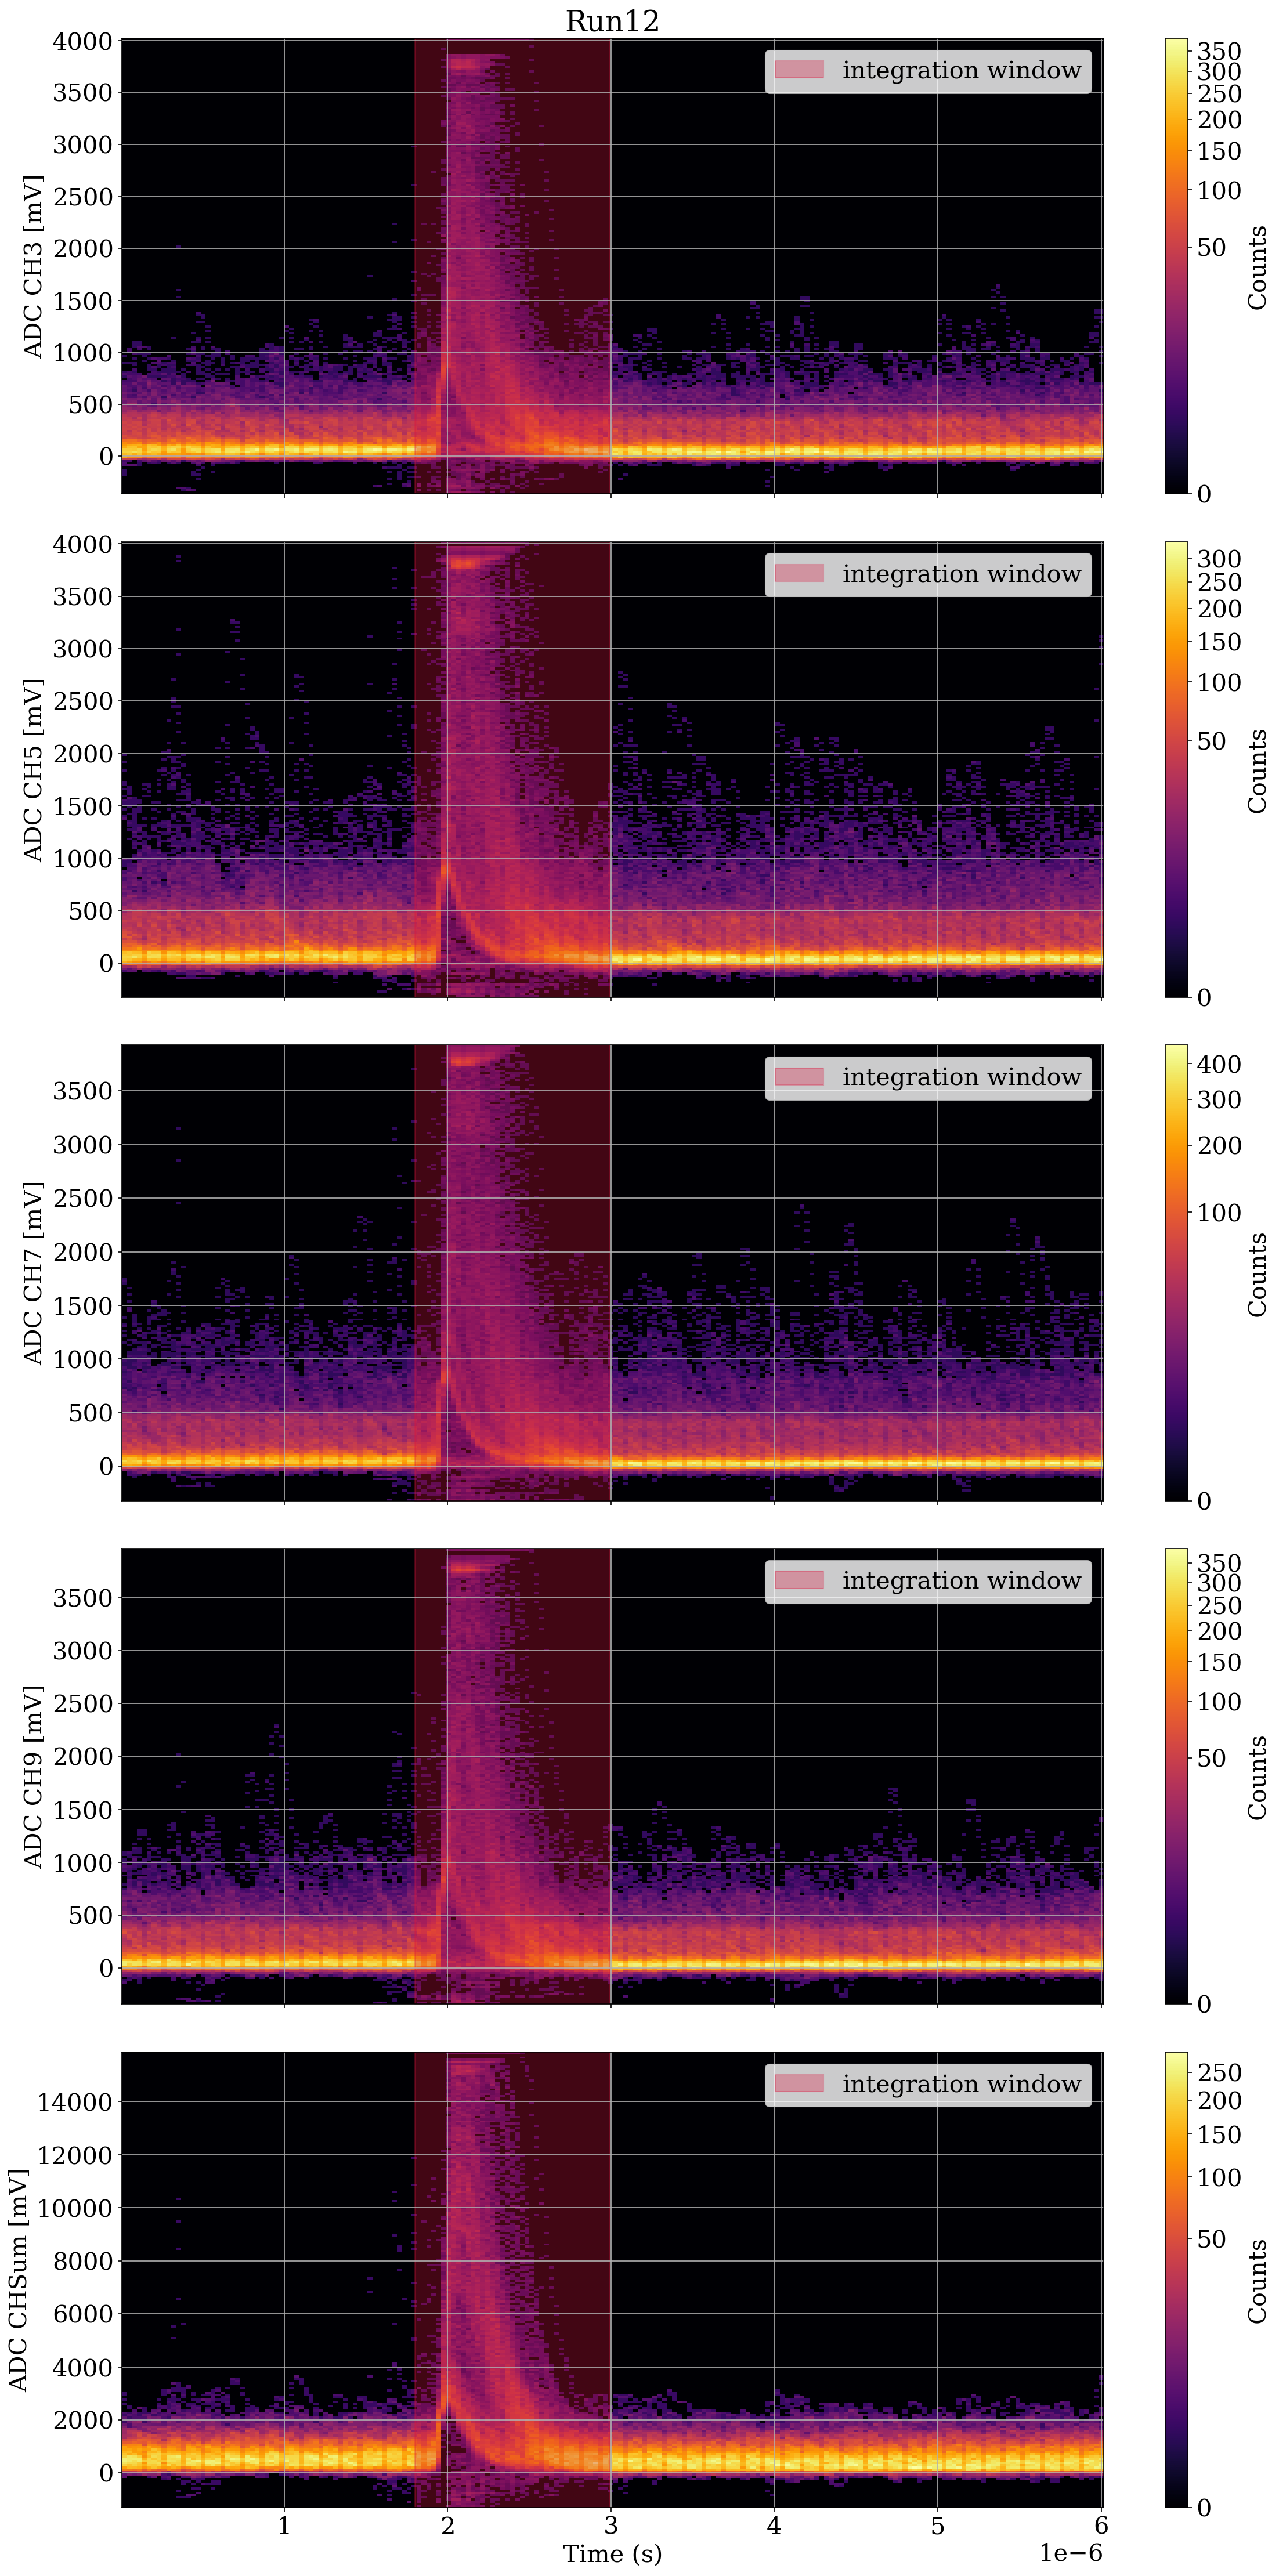

In [26]:
# Create subplots: 2 rows, 1 column

if len(channels) > 1:
    fig, axs = plt.subplots(len(channels), 1, figsize=(16, len(channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(channels) > 1:
    axs[0].set_title(f'{run_Kr}')
else:
    ax.set_title(f'{run_Kr}')


# Plot CHs
for i in range(len(channels)):

    if len(channels) > 1:
        ax = axs[i]

    voltage  = corrected_df_Kr[f'{channels[i]}'].values
    v_matrix = voltage.reshape(nevents_Kr, -1)
    # v_matrix_corrected, baselines, window = cig.BaselineCorrection(v_matrix, window=window_width)
    v_matrix_corrected = v_matrix
    
    # voltage_matrix = np.array([...]) # shape (nevents, nsamples)
    hb = ax.hist2d(t_matrix_Kr.flatten(), v_matrix_corrected.flatten(), bins=[200, 200], 
                   cmap='inferno', norm=mcolors.PowerNorm(gamma=0.3))

    fig.colorbar(hb[3], ax=ax, label="Counts")

    ax.fill_between(time_Kr[time_window_Kr], v_matrix_corrected.min(), v_matrix_corrected.max(), 
                    color = colors[1], alpha = 0.3, label = 'integration window')

    ax.set_ylabel(f'ADC {channels[i]} [mV]')
    ax.grid(True)
    ax.legend()

if len(channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

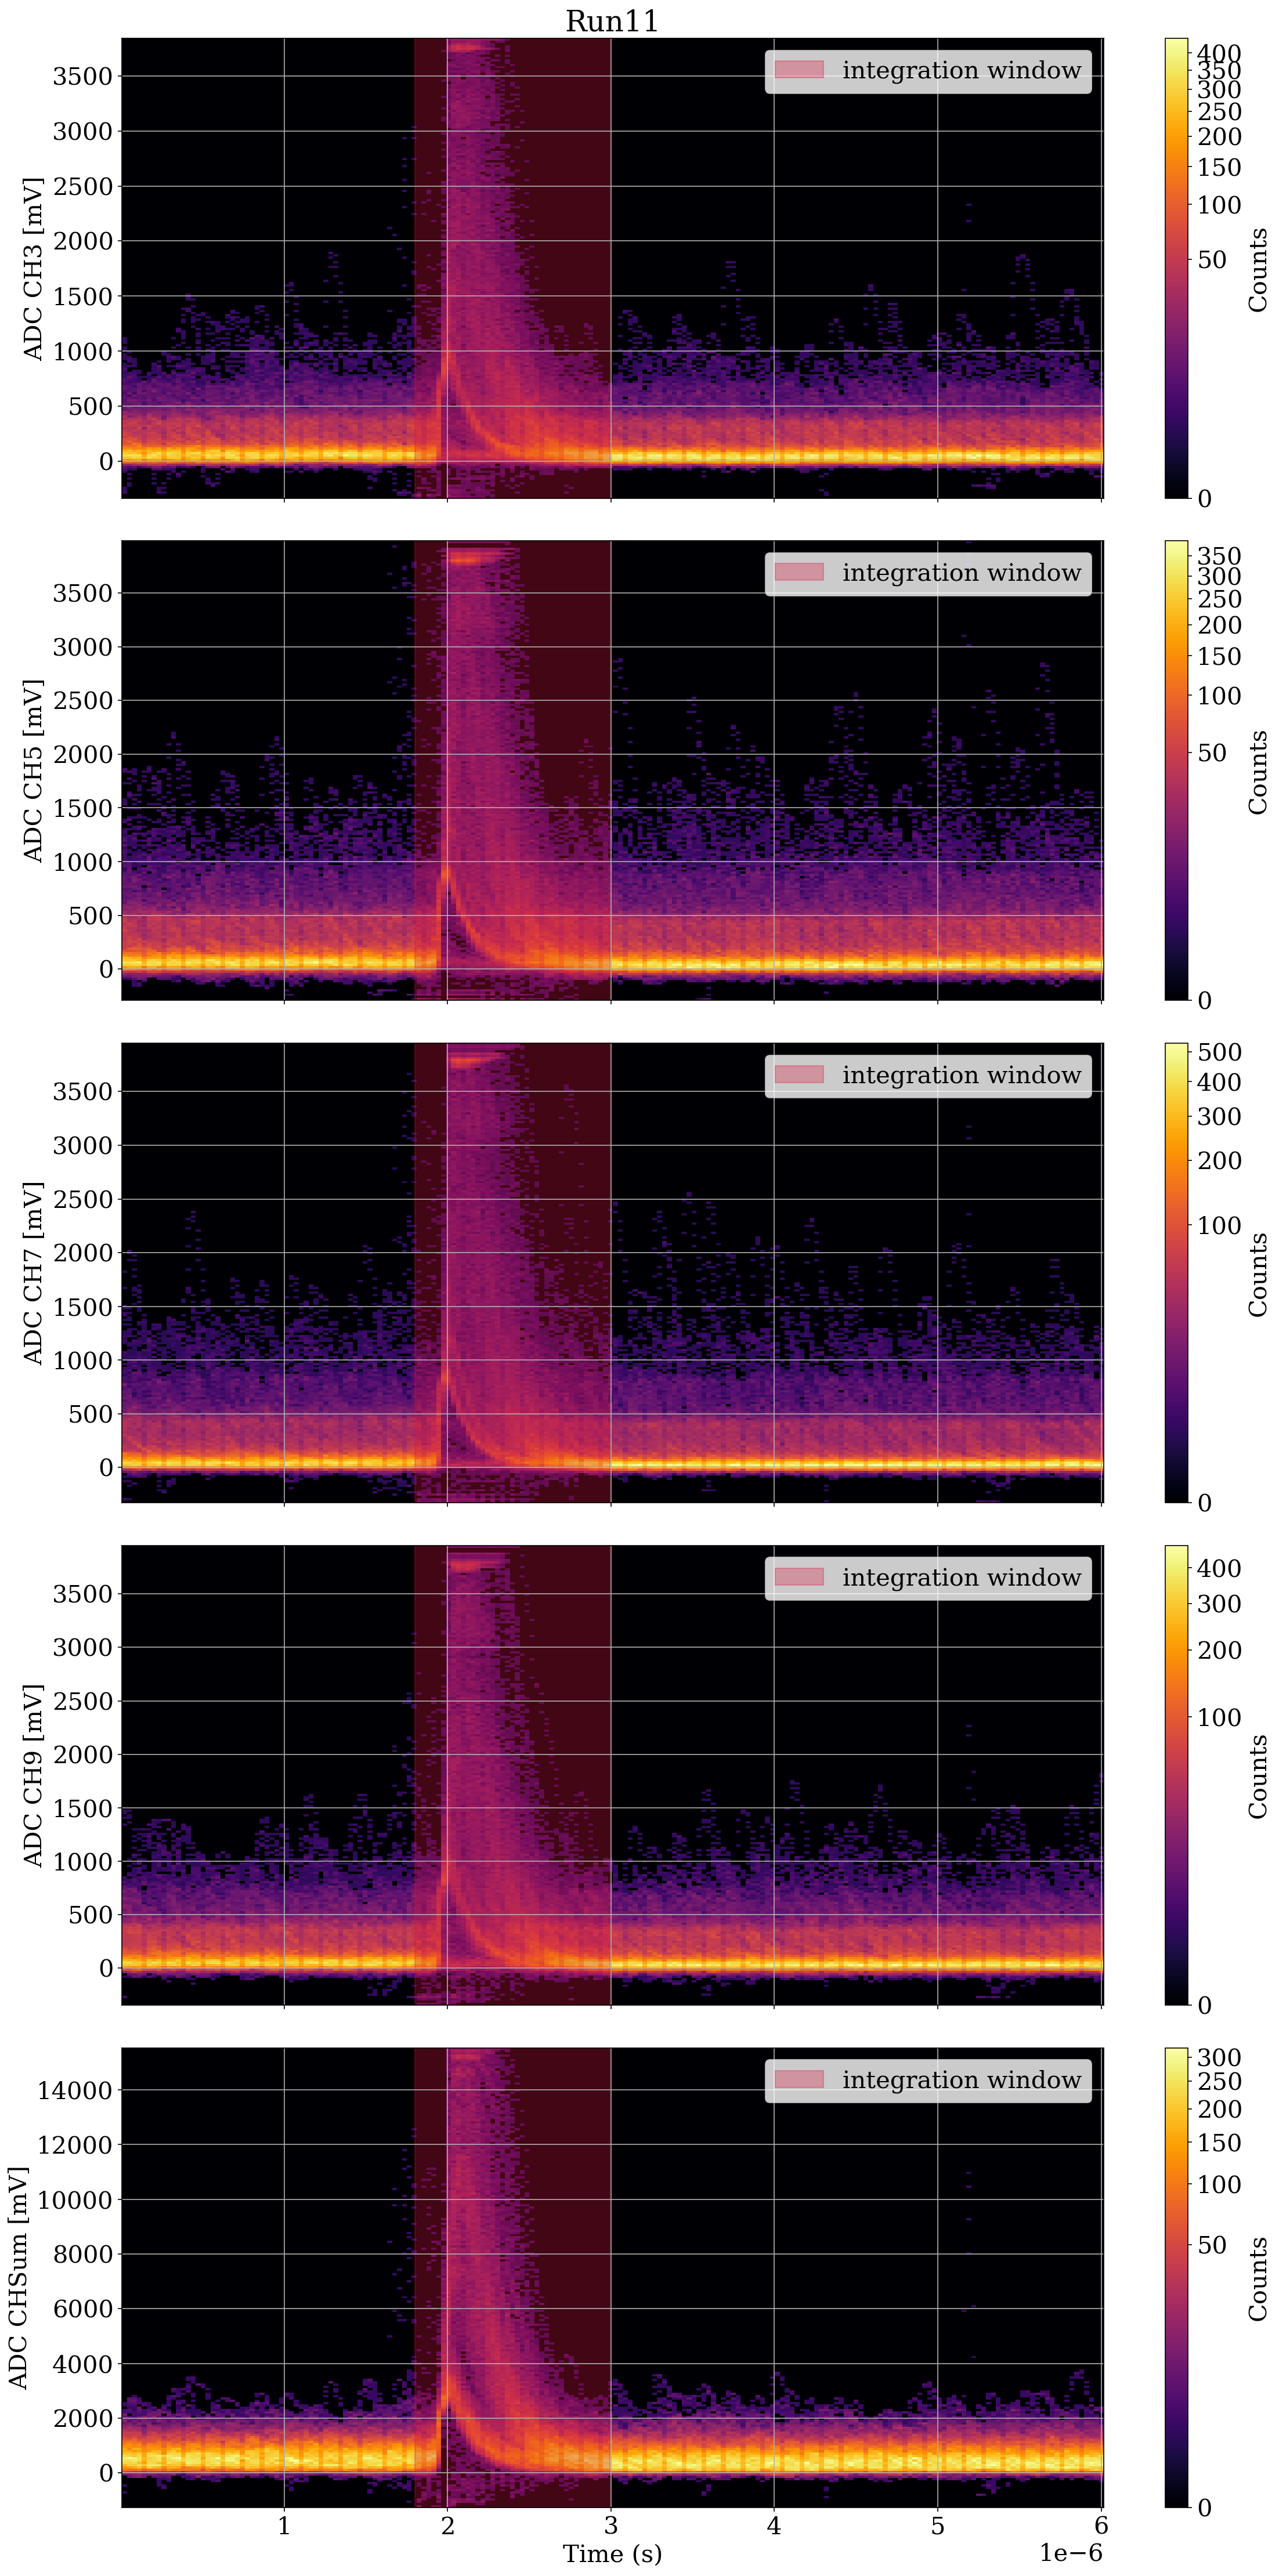

In [27]:
# Create subplots: 2 rows, 1 column

if len(channels) > 1:
    fig, axs = plt.subplots(len(channels), 1, figsize=(16, len(channels)*6), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(16, 6), dpi=150, sharex=True)

if len(channels) > 1:
    axs[0].set_title(f'{run_noKr}')
else:
    ax.set_title(f'{run_noKr}')


# Plot CHs
for i in range(len(channels)):

    if len(channels) > 1:
        ax = axs[i]

    voltage  = corrected_df_noKr[f'{channels[i]}'].values
    v_matrix = voltage.reshape(nevents_noKr, -1)
    # v_matrix_corrected, baselines, window = cig.BaselineCorrection(v_matrix, window=window_width)
    v_matrix_corrected = v_matrix
    
    # voltage_matrix = np.array([...]) # shape (nevents, nsamples)
    hb = ax.hist2d(t_matrix_noKr.flatten(), v_matrix_corrected.flatten(), bins=[200, 200], 
                   cmap='inferno', norm=mcolors.PowerNorm(gamma=0.3))

    fig.colorbar(hb[3], ax=ax, label="Counts")

    ax.fill_between(time_noKr[time_window_noKr], v_matrix_corrected.min(), v_matrix_corrected.max(), 
                    color = colors[1], alpha = 0.3, label = 'integration window')

    ax.set_ylabel(f'ADC {channels[i]} [mV]')
    ax.grid(True)
    ax.legend()

if len(channels) > 1:
    axs[-1].set_xlabel('Time (s)')
else:
    ax.set_xlabel('Time (s)')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

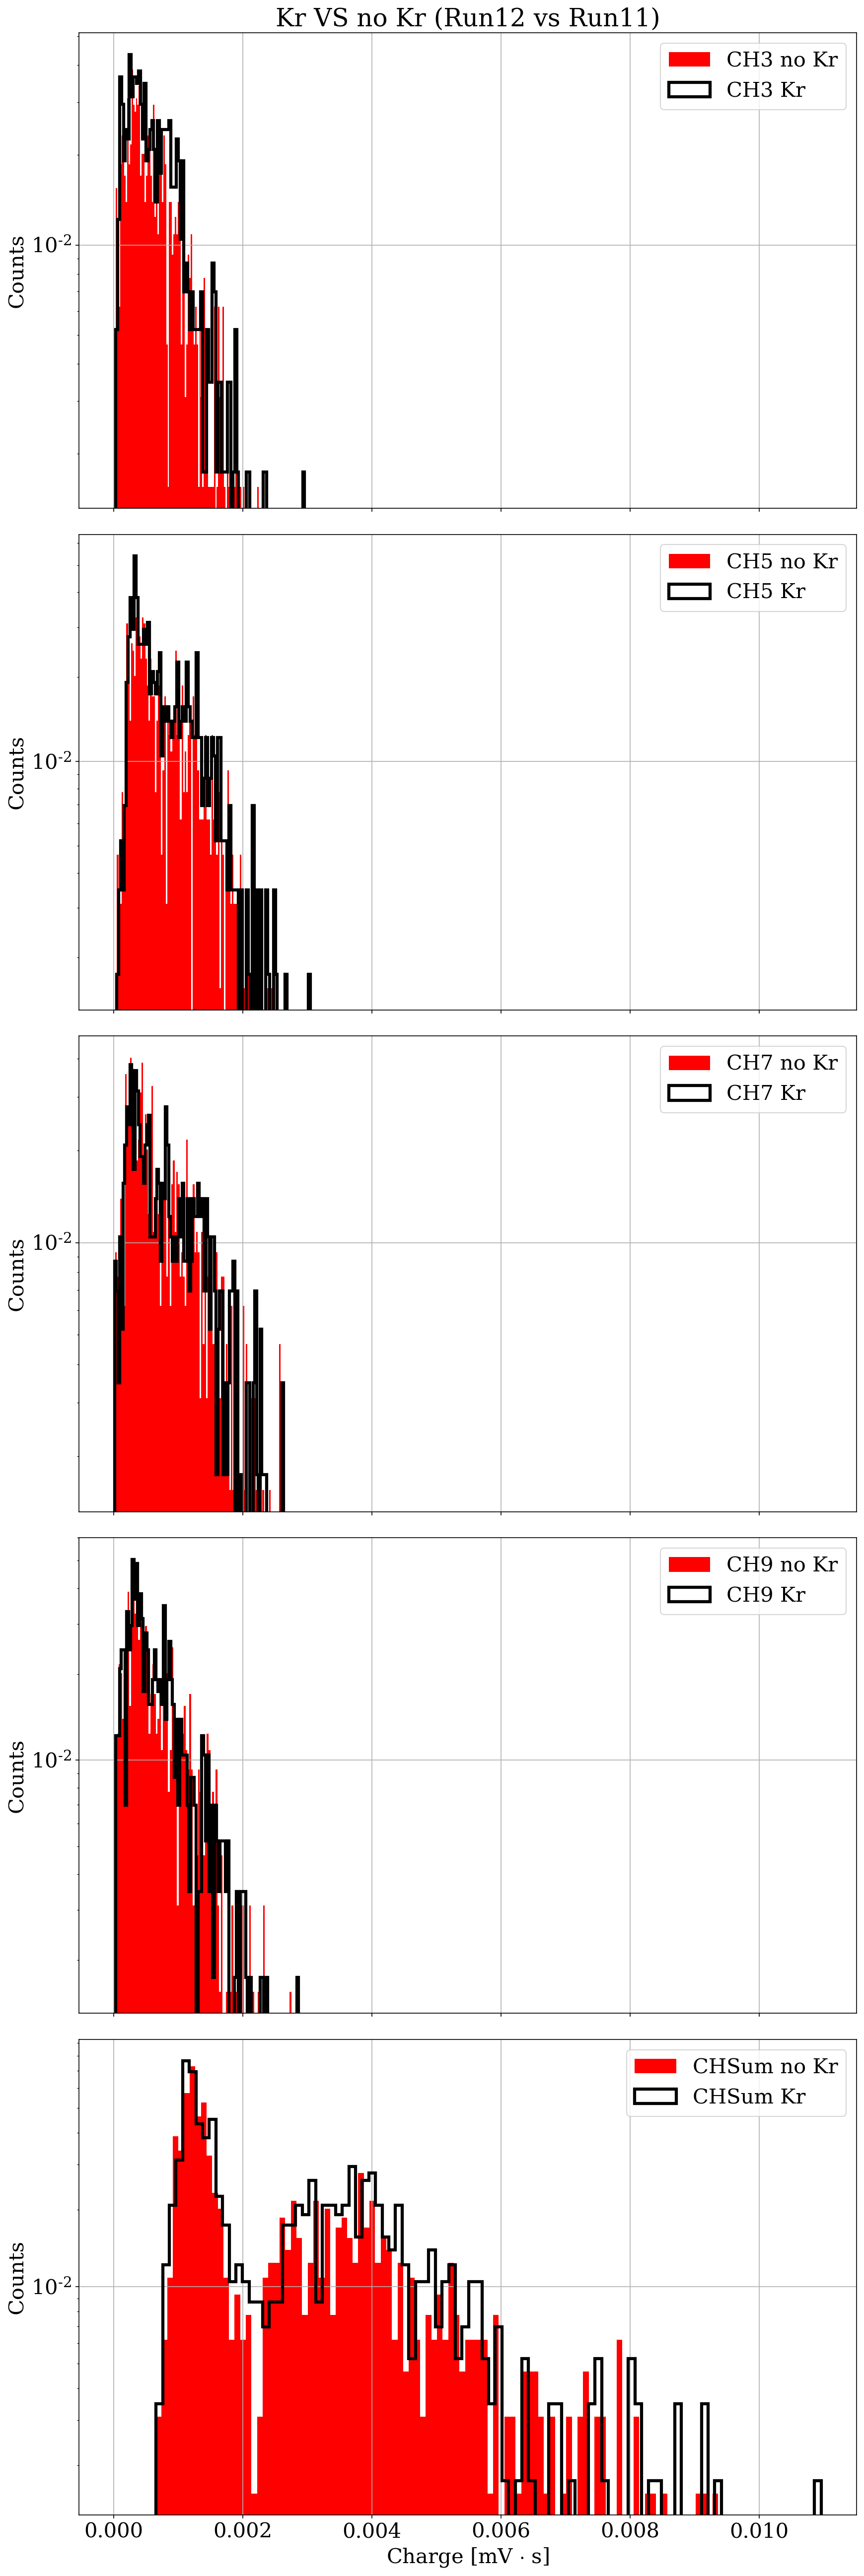

In [28]:
# Create subplots: 2 rows, 1 column

if len(channels) > 1:
    fig, axs = plt.subplots(len(channels), 1, figsize=(12, len(channels)*7), dpi=150, sharex=True)
else:
    fig, ax = plt.subplots(1, 1, figsize=(12, 7), dpi=150, sharex=True)

if len(channels) > 1:
    axs[0].set_title(f'Kr VS no Kr ({run_Kr} vs {run_noKr})')
else:
    ax.set_title(f'Kr VS no Kr ({run_Kr} vs {run_noKr})')


# Plot CHs
for i, ch in enumerate(channels):

    if len(channels) > 1:
        ax = axs[i]
    
    # NO KR -------------------------------------------------------------------------
    voltage_noKr = corrected_df_noKr[f'{channels[i]}'].values

    v_matrix_noKr                    = voltage_noKr.reshape(nevents_noKr, -1)
    # v_matrix_corrected_noKr, _, _    = cig.BaselineCorrection(v_matrix_noKr, window=window_width)
    v_matrix_corrected_noKr = v_matrix_noKr

    charge_noKr = np.trapz(v_matrix_corrected_noKr[:, time_window_noKr],
                      x = time_noKr[time_window_noKr]
                      ,axis = 1)

    events_noKr, bins, image = ax.hist(charge_noKr
                                ,bins = 100 
                                ,weights=np.ones_like(charge_noKr)/nevents_noKr
                                ,density = False
                                ,histtype   ='stepfilled'
                                ,color      = 'r'
                                ,ls         = '-'
                                ,lw         = 3
                                ,alpha      = 1
                                ,label = f'{ch} no Kr'
                                )
    
    # KR -------------------------------------------------------------------------
    voltage_Kr = corrected_df_Kr[f'{channels[i]}'].values

    v_matrix_Kr                    = voltage_Kr.reshape(nevents_Kr, -1)
    # v_matrix_corrected_Kr, _, _    = cig.BaselineCorrection(v_matrix_Kr, window=window_width)
    v_matrix_corrected_Kr = v_matrix_Kr

    charge_Kr = np.trapz(v_matrix_corrected_Kr[:, time_window_Kr],
                      x = time_Kr[time_window_Kr]
                      ,axis = 1)

    events_Kr, bins, image = ax.hist(charge_Kr
                                ,bins = 100 
                                ,weights=np.ones_like(charge_Kr)/nevents_Kr
                                ,density = False
                                ,histtype   ='step'
                                ,color      = 'k'
                                ,ls         = '-'
                                ,lw         = 3
                                ,alpha      = 1
                                ,label = f'{ch} Kr'
                                )
    
    ax.set_ylabel(f'Counts')
    ax.grid(True)
    ax.set_yscale('log')
    ax.legend()

if len(channels) > 1:
    axs[-1].set_xlabel(r'Charge [mV $\cdot$ s]')
else:
    ax.set_xlabel(r'Charge [mV $\cdot$ s]')

# plt.xlim(-2e-7,40e-7)

# Improve layout
plt.tight_layout()
plt.show()

In [29]:
events_Kr.sum(), events_noKr.sum()

(1.0, 1.0)